# YOLO in TensorFlow 2.0

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
!ls

adc.json  drive  sample_data


In [4]:
!cd drive

In [5]:
!ls

adc.json  drive  sample_data


In [6]:
!cd drive

In [7]:
ls

adc.json  drive/  sample_data/


In [8]:
cd drive

/content/drive


In [9]:
ls

 2014_11_09_Quiz_Instructions_and_sample_answers.pdf
 400_tamu_substitute_w9s-converted.docx
 400_tamu_substitute_w9s.pdf
 Abstract.desktop
 Abstract.docx
'Araku Economic details.desktop'
'Araku Economic Details.desktop'
'Arduino project.desktop'
 Assgn3_HA.pdf
'Basics of RC Planes.pptx'
'Basics of RC Planes.pptx.desktop'
'Behaviour of a Competitive Firm.pdf'
'Check out 2 Cars'
'Colab Notebooks'/
'Copy of format of the report.desktop'
'Copy of Untitled Diagram.drawio'
'Crash (07392646).pptx'
'Crash (13040d7b).pptx'
'Crash (507254e8).pptx'
'Crash (a7da7c3a).pptx'
'Crash (d4bdabe4).pptx'
'Crash Data Analysis.rar'
 Crash.pptx
 degree.pdf
'DL_HW2 (68c3a409).ipynb'
 DL_HW2.ipynb
 DSC00698.JPG
 DSC00699.JPG
 DSC00700.JPG
 DSC00701.JPG
 DSC00702.JPG
 DSC00703.JPG
'ECEN 642'/
 ECEN-649:.desktop
 ee224/
'Elec lab III.desktop'
'Elec Lab Report.desktop'
'Elec Lab report - I.desktop'
 EP219Tut5.docx
 EP219Tut6.docx
 EP-223_2015-1_EndsemSchedule.pdf
 EP315_140260027.pdf
'Fall 2k19 Courses.desktop'


In [10]:
cd YOLOV4/

/content/drive/YOLOV4


In [11]:
cd yolov3/

/content/drive/YOLOV4/yolov3


In [12]:
ls

 1.PNG                                    output.jpg              YOLOV4.ipynb
 checkpoints/                            'Screenshot (398).png'   yolo.weights
 dog.jpg                                 'Screenshot (775).png'
 Object_Detection_YOLO_Tensorflow.ipynb  'Screenshot (924).png'


Tensorflow 2.0 is required

Choose TensorFlow 2.x in Colab using the method shown below

In [ ]:
%tensorflow_version 2.x

In [ ]:
!pip show tensorflow

Download the weights file

Download weights from the link below and paste it in your drive where Object_Detection_YOLO_Tensorflow is present.

https://drive.google.com/file/d/1dwtJg0ezh5LzvOP9tK77HofDF1LQP1XD/view?usp=sharing)

Prepare the folder for storing the weights

In [ ]:
!rm -rf checkpoints

In [ ]:
!mkdir checkpoints

Import all required libraries

In [13]:
import cv2
import numpy as np
import tensorflow as tf

from absl import logging
from itertools import repeat
from google.colab.patches import cv2_imshow

from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

Define some imporant value which we will use later

In [14]:
yolo_iou_threshold   = 0.6 # iou threshold
yolo_score_threshold = 0.6 # score threshold

weightsyolo = 'yolo.weights' # path to weights file
weights= 'checkpoints/yolo.tf' # path to checkpoints file
size= 416             #resize images to\
checkpoints = 'checkpoints/yolo.tf'
num_classes = 80      # number of classes in the model

List of layers in YOLO FCN — Fully Convolutional Network

In [15]:
YOLO_LAYERS = [
  'yolo_darknet',
  'yolo_conv_0',
  'yolo_output_0',
  'yolo_conv_1',
  'yolo_output_1',
  'yolo_conv_2',
  'yolo_output_2',
]

Function to load weights from original Yolo trained model in Darknet

In [16]:
def load_darknet_weights(model, weights_file):
  wf = open(weights_file, 'rb')
  major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
  layers = YOLO_LAYERS

  for layer_name in layers:
    sub_model = model.get_layer(layer_name)
    for i, layer in enumerate(sub_model.layers):
      if not layer.name.startswith('conv2d'):
        continue
      batch_norm = None
      if i + 1 < len(sub_model.layers) and \
            sub_model.layers[i + 1].name.startswith('batch_norm'):
        batch_norm = sub_model.layers[i + 1]

      logging.info("{}/{} {}".format(
        sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

      filters = layer.filters
      size = layer.kernel_size[0]
      in_dim = layer.input_shape[-1]

      if batch_norm is None:
        conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
      else:
        bn_weights = np.fromfile(
          wf, dtype=np.float32, count=4 * filters)

        bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

      conv_shape = (filters, in_dim, size, size)
      conv_weights = np.fromfile(
        wf, dtype=np.float32, count=np.product(conv_shape))

      conv_weights = conv_weights.reshape(
        conv_shape).transpose([2, 3, 1, 0])

      if batch_norm is None:
        layer.set_weights([conv_weights, conv_bias])
      else:
        layer.set_weights([conv_weights])
        batch_norm.set_weights(bn_weights)

  assert len(wf.read()) == 0, 'failed to read all data'
  wf.close()

Define function for calculating intersection over union

In [17]:
def interval_overlap(interval_1, interval_2):
  x1, x2 = interval_1
  x3, x4 = interval_2
  if x3 < x1:
    return 0 if x4 < x1 else (min(x2,x4) - x1)
  else:
    return 0 if x2 < x3 else (min(x2,x4) - x3)

def intersectionOverUnion(box1, box2):
  intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
  intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
  intersect_area = intersect_w * intersect_h
  
  w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
  w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
  
  union_area = w1*h1 + w2*h2 - intersect_area
  return float(intersect_area) / union_area

Function for drawing bounding box, class name and probability

In [18]:
def draw_outputs(img, outputs, class_names):
  boxes, score, classes, nums = outputs
  boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
  wh = np.flip(img.shape[0:2])
  for i in range(nums):
    x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
    #x1y1 = (np.array(boxes[i][0:2]) * wh).astype(np.int32)
    #print("x1y1 here")
    #print(x1y1)
    x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
    #x2y2 = (np.array(boxes[i][2:4]) * wh).astype(np.int32)
    #print(x2y2)
    #print(img.shape)
    bbox_array = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
    bbox_array = cv2.putText(img, '{} {:.4f}'.format(
      class_names[int(classes[i])], score[i]),
      x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    #bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    #print("bbox_array shape here")
    #print(bbox_array.shape)
  return bbox_array

In [19]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
  def call(self, x, training=False):
    if training is None: training = tf.constant(False)
    training = tf.logical_and(training, self.trainable)
    return super().call(x, training)

Defining 3 anchor boxes for each grid

In [20]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])



---



Create custom layers and model

In [21]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
  if strides == 1:
    padding = 'same'
  else:
    x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
    padding = 'valid'
  x = Conv2D(filters=filters, kernel_size=size,
          strides=strides, padding=padding,
          use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
  if batch_norm:
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
  return x

def DarknetResidual(x, filters):
  previous  = x
  x = DarknetConv(x, filters // 2, 1)
  x = DarknetConv(x, filters, 3)
  x = Add()([previous , x])
  return x


def DarknetBlock(x, filters, blocks):
  x = DarknetConv(x, filters, 3, strides=2)
  for _ in repeat(None, blocks):
    x = DarknetResidual(x, filters)       
  return x


def Darknet(name=None):
  x = inputs = Input([None, None, 3])
  x = DarknetConv(x, 32, 3)
  x = DarknetBlock(x, 64, 1)
  x = DarknetBlock(x, 128, 2)
  x = x_36 = DarknetBlock(x, 256, 8)
  x = x_61 = DarknetBlock(x, 512, 8)
  x = DarknetBlock(x, 1024, 4)
  return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [22]:
def YoloConv(filters, name=None):
  def yolo_conv(x_in):
    if isinstance(x_in, tuple):
      inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
      x, x_skip = inputs

      x = DarknetConv(x, filters, 1)
      x = UpSampling2D(2)(x)
      x = Concatenate()([x, x_skip])
    else:
      x = inputs = Input(x_in.shape[1:])

    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    return Model(inputs, x, name=name)(x_in)
  return yolo_conv

In [23]:
def YoloOutput(filters, anchors, classes, name=None):
  def yolo_output(x_in):
    x = inputs = Input(x_in.shape[1:])
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
    x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
    return tf.keras.Model(inputs, x, name=name)(x_in)
  return yolo_output

In [24]:
def yolo_boxes(pred, anchors, classes):
  grid_size = tf.shape(pred)[1]
  box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1)

  box_xy = tf.sigmoid(box_xy)
  score = tf.sigmoid(score)
  class_probs = tf.sigmoid(class_probs)
  pred_box = tf.concat((box_xy, box_wh), axis=-1)

  grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
  grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

  box_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32)
  box_wh = tf.exp(box_wh) * anchors

  box_x1y1 = box_xy - box_wh / 2
  box_x2y2 = box_xy + box_wh / 2
  bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

  return bbox, score, class_probs, pred_box

In [25]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
  boxes, conf, out_type = [], [], []

  for output in outputs:
    boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
    conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
    out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

  bbox = tf.concat(boxes, axis=1)
  confidence = tf.concat(conf, axis=1)
  class_probs = tf.concat(out_type, axis=1)

  scores = confidence * class_probs
  
  boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
    boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
    scores=tf.reshape(
        scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
    max_output_size_per_class=100,
    max_total_size=100,
    iou_threshold=yolo_iou_threshold,
    score_threshold=yolo_score_threshold
  )
  
  return boxes, scores, classes, valid_detections

In [26]:
def Yolo(size=None, channels=3, anchors=yolo_anchors,
          masks=yolo_anchor_masks, classes=80, training=False):
  x = inputs = Input([size, size, channels])

  x_36, x_61, x = Darknet(name='yolo_darknet')(x)

  x = YoloConv(512, name='yolo_conv_0')(x)
  output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

  x = YoloConv(256, name='yolo_conv_1')((x, x_61))
  output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

  x = YoloConv(128, name='yolo_conv_2')((x, x_36))
  output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

  if training:
    return Model(inputs, (output_0, output_1, output_2), name='yolo')

  boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
  boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
  boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

  outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

  return Model(inputs, outputs, name='yolo')

In [27]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(broadcast_iou(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [28]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

  N = tf.shape(y_true)[0]

  y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

  anchor_idxs = tf.cast(anchor_idxs, tf.int32)

  indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
  updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
  idx = 0
  for i in tf.range(N):
    for j in tf.range(tf.shape(y_true)[1]):
      if tf.equal(y_true[i][j][2], 0):
        continue
      anchor_eq = tf.equal(
        anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

      if tf.reduce_any(anchor_eq):
        box = y_true[i][j][0:4]
        box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

        anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
        grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

        indexes = indexes.write(
            idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
        updates = updates.write(
          idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
        idx += 1

  return tf.tensor_scatter_nd_update(
    y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
  outputs = []
  grid_size = 13

  anchors = tf.cast(anchors, tf.float32)
  anchor_area = anchors[..., 0] * anchors[..., 1]
  box_wh = y_train[..., 2:4] - y_train[..., 0:2]
  box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
  box_area = box_wh[..., 0] * box_wh[..., 1]
  intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
  iou = intersection / (box_area + anchor_area - intersection)
  anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
  anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

  y_train = tf.concat([y_train, anchor_idx], axis=-1)

  for anchor_idxs in anchor_masks:
    outputs.append(transform_targets_for_output(
      y_train, grid_size, anchor_idxs, classes))
    grid_size *= 2

  return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
  return (tf.image.resize(x_train, (size, size))) / 255

Now we can create our model, load weights and class names. There is 80 of them in Coco dataset. Straight away we can go and test our model with some image.

In [29]:
yolo = Yolo(classes=num_classes)

load_darknet_weights(yolo, weightsyolo)

yolo.save_weights(checkpoints)

class_names =  ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
  "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
  "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
  "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
  "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
  "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
  "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
  "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
  "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
  "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

print(class_names[0])

person


In [ ]:
print(class_names[0])

In [ ]:
# In order to test our object detection algorithm, we 
# are going to upload some image from computer
# Other methods can be utilized, for example
# download from internet or google drive
from google.colab import files

image = files.upload()
image = list(image.keys())[0]
image = cv2.imread(image)

name = 'dog.jpg'     # path to test image
cv2.imwrite(name, image)

In [33]:
name = 'dog.jpg'
#cv2.imwrite(name, image)
img = tf.image.decode_image(open(name, 'rb').read(), channels=3)
print(img.shape)
img = tf.expand_dims(img, 0)
print(img.shape)
img = preprocess_image(img, size)
print(size)
print(img.shape)

(1080, 1920, 3)
(1, 1080, 1920, 3)
416
(1, 416, 416, 3)


In [35]:
print(img.shape)
boxes, scores, classes, nums = yolo(img) #eager mode


(1, 416, 416, 3)


image shape here
(1080, 1920, 3)


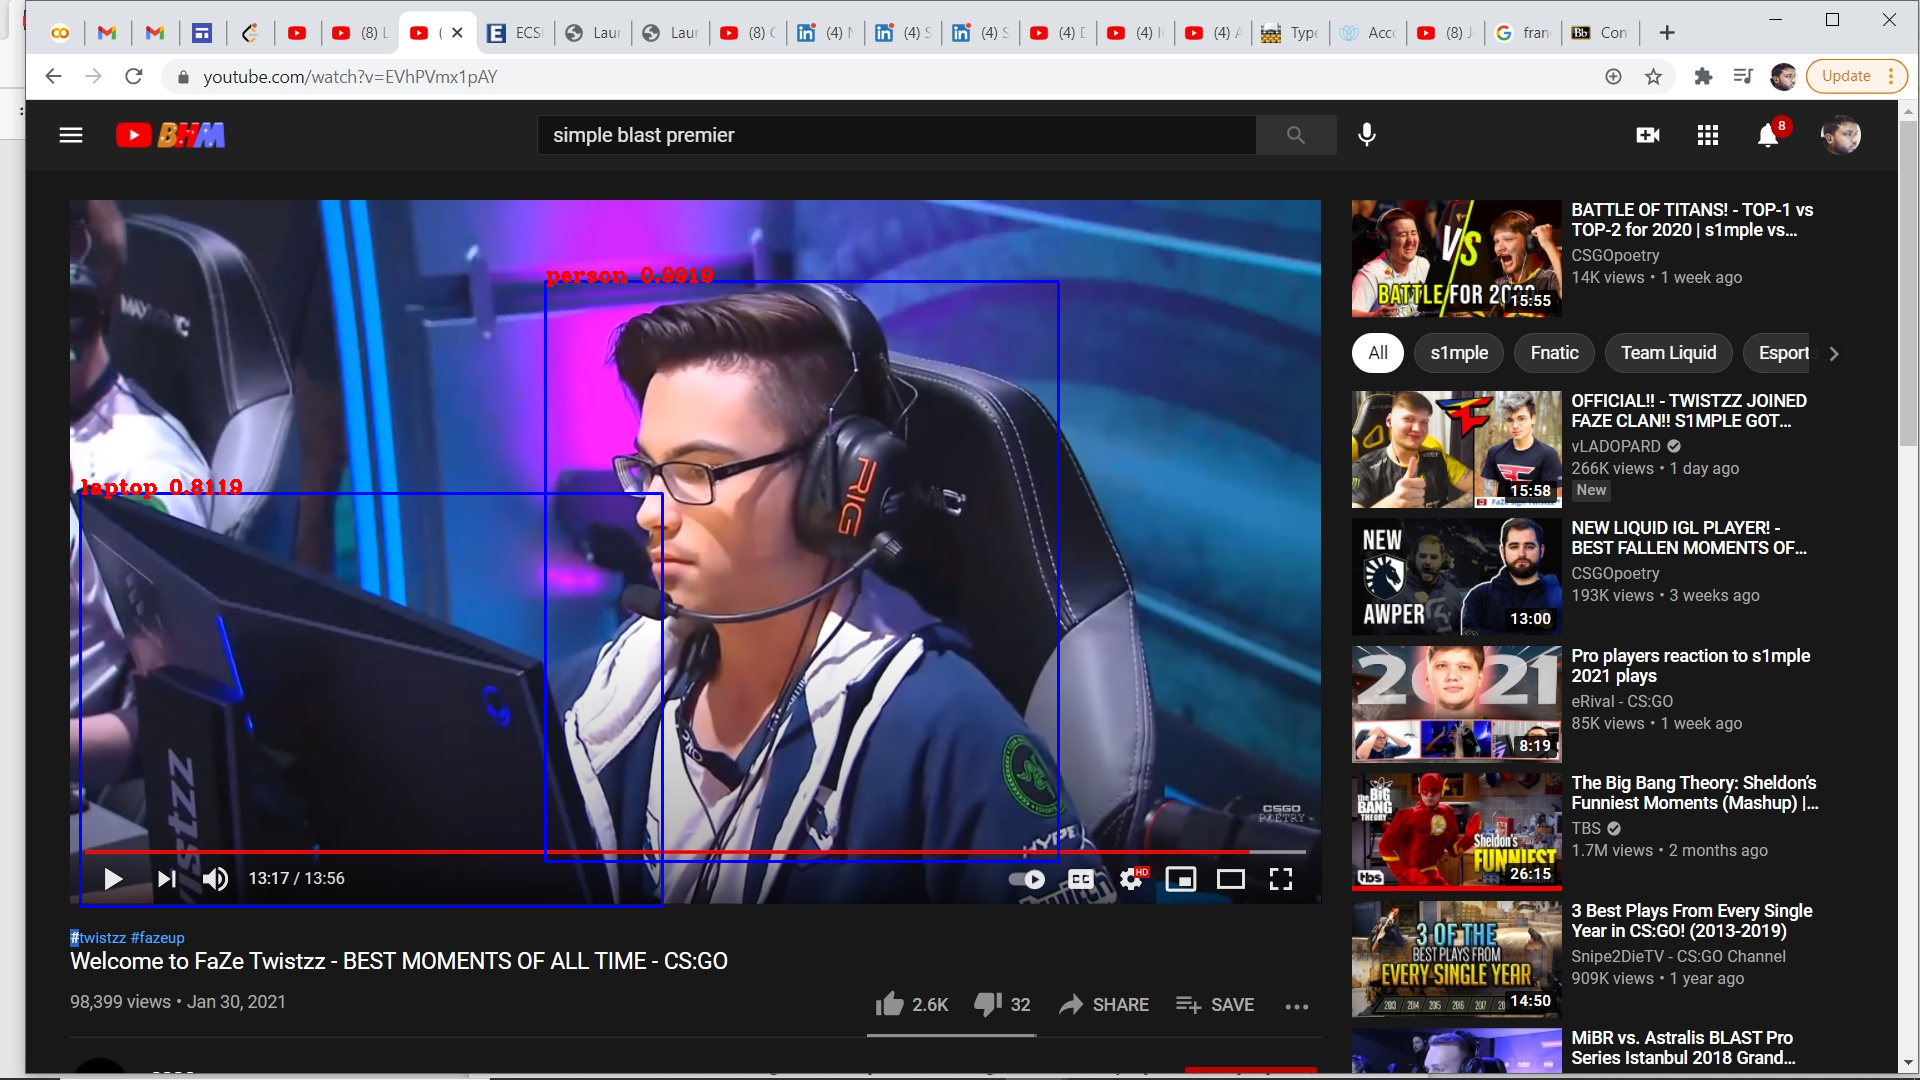

In [36]:
img = cv2.imread(name)
print("image shape here")
print(img.shape)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2.imwrite('output.jpg', img)
cv2_imshow(img)

Below is a function to start up the video stream using similar JavaScript as was used for images. The video stream frames are fed as input to YOLO.




In [37]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [38]:


# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [40]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    #print(frame.shape)

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our yolo on video frame
    
    img = tf.expand_dims(frame, 0)
    img = preprocess_image(img, size)
    

    boxes, scores, classes, nums = yolo(img)

    #img = cv2.imread(frame)
    #print(boxes.shape)
    #print(scores.shape)
    #print(classes.shape)
    #print(nums.shape)
    bbox_array = draw_outputs(bbox_array, (boxes, scores, classes, nums), class_names)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    #convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    #update bbox so next frame gets new overlay
    bbox = bbox_bytes

    

<IPython.core.display.Javascript object>

**References**

[1. Proctoring-AI](https://github.com/vardanagarwal/Proctoring-AI/blob/master/person_and_phone.py)


[2. YoloDarknet-Webcam](https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial/blob/master/yolov4_webcam.ipynb)



---



---





---



---

